In [1]:
%load_ext pycodestyle_magic
%flake8_on

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from functions import *
from pandas_profiling import ProfileReport
import timeit
import datetime

# preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer

# modelisation
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import davies_bouldin_score, silhouette_score
from sklearn import decomposition

5:1: F403 'from functions import *' used; unable to detect undefined names


In [3]:
%matplotlib inline

# FONCTIONS

In [4]:
def suppression_lignes_silent(df, masque):
    """
    suppression des lignes d'un df à partir d'un masque

    retourne : df_cleaned = df où les lignes ont été enlevées
    """
    df_cleaned = df.drop(df[masque].index)
    return df_cleaned

In [5]:
def calcul_features(df):
    '''
    fonction qui calcul les différentes features utilisées pour le calcul
    du clustering en entrée : df qui regroupe toutes les informations
    nécessaires au calcul des features
    en sortie : df client qui regroupe les features par customer_unique_id
    '''
    # initialisation du fichier qui va regrouper toutes les variables créées par client.
    client = pd.DataFrame()
    client['customer_unique_id'] = df['customer_unique_id'].unique()

    # Calcul du montant moyen dépensé par client
    montant = df[['customer_unique_id',
                  'payment_value']].groupby('customer_unique_id').mean()
    client = client.merge(montant, on='customer_unique_id', how='left')
    client = client.rename(columns={'payment_value': 'Montant dépensé'})

    # Calcul du nb de jours entre la dernière commande et la date max de commande du fichier
    recence = df[['customer_unique_id']].reset_index()
    recence = recence.groupby('customer_unique_id').max()
    client = client.merge(recence, on='customer_unique_id', how='left')
    client = client.rename(columns={'order_purchase_timestamp': 'Récence'})
    # date la plus récente du fichier
    date_max = df.index.max()
    client['Récence'] = (date_max - client['Récence']).dt.days

    # nombre de commandes par client
    df_temp = df[['order_id', 'customer_unique_id']].groupby(by=['order_id', 'customer_unique_id']).sum().reset_index()
    nb_commandes_par_client = df_temp.groupby('order_id').count().reset_index().drop('customer_unique_id', axis=1)
    nb_commandes_par_client = nb_commandes_par_client.merge(df_temp,
                                                            on='order_id',
                                                            how='left')
    nb_commandes_par_client = nb_commandes_par_client.groupby('customer_unique_id').count()
    nb_commandes_par_client = nb_commandes_par_client.rename(columns={'order_id': 'nb commande par client'})
    client = client.merge(nb_commandes_par_client,
                          on='customer_unique_id',
                          how='left')

    # Satisfaction moyenne du client
    satisfaction = df[['customer_unique_id', 'review_score']]
    satisfaction = satisfaction.groupby('customer_unique_id').mean()
    satisfaction = satisfaction.rename(columns={'review_score': 'satisfaction'})
    client = client.merge(satisfaction, on='customer_unique_id', how='left')

    # nombre moyen d'item par commande
    # 1.calcul du nb total d'item par client
    nb_item_tot_par_client = df[['customer_unique_id', 'order_item_id']].groupby('customer_unique_id').count()
    nb_item_tot_par_client = nb_item_tot_par_client.rename(columns={'order_item_id': 'nb total item par client'})
    client = client.merge(nb_item_tot_par_client, on='customer_unique_id', how='left')
    # 2. calcul du nb d'item par commande
    client['nb item par commande'] = client['nb total item par client'] / client['nb commande par client']
    # suppression nb item total par client
    client = client.drop('nb total item par client', axis=1)

    return client

8:80: E501 line too long (88 > 79 characters)
18:80: E501 line too long (92 > 79 characters)
28:80: E501 line too long (119 > 79 characters)
29:80: E501 line too long (114 > 79 characters)
33:80: E501 line too long (91 > 79 characters)
34:80: E501 line too long (108 > 79 characters)
42:80: E501 line too long (80 > 79 characters)
47:80: E501 line too long (110 > 79 characters)
48:80: E501 line too long (113 > 79 characters)
49:80: E501 line too long (86 > 79 characters)
51:80: E501 line too long (106 > 79 characters)


In [6]:
def accuracy_clustering(labels_true, labels_pred):
    '''
    calcul du score d'accuracy entre le label de reference (M0)
    et le label prédit il faut d'abord faire la correspondance
    entre les labels via une matrice de confusion
    '''
    # calcul de la matrice de confusion
    cm = confusion_matrix(labels_true, labels_pred)
    # alignement le long de la diagonale des correspondances des clusters
    labels_pred_modif = labels_pred.copy()
    for i in range(0, 6):
        if np.argmax(cm, axis=1)[i] == i:
            next
        else:
            labels_pred_modif[labels_pred == np.argmax(cm, axis=1)[i]] = i
    score_accuracy = accuracy_score(labels_true, labels_pred_modif)

    return score_accuracy

In [7]:
def calcul_modele(X, model_M0, nb_cluster):
    '''
    fonction qui va permettre de calculer les nouveaux modèles et comparer
    avec le modèle de référence + stocker les résultats du calcul de l'ARI
    '''

    # mise en place du pipelines pour les données quantitatives
    X_quanti = list(X.select_dtypes(['float64', 'int64']).columns)
    quanti_pipeline = make_pipeline(StandardScaler())
    preprocessor_quanti = make_column_transformer((quanti_pipeline, X_quanti))

    labels_true = model_M0.predict(X)
    model_new = make_pipeline(preprocessor_quanti,
                              KMeans(n_clusters=nb_cluster,
                                     random_state=0))

    labels_pred = model_new.fit_predict(X)
    ARI = adjusted_rand_score(labels_true, labels_pred)
    accuracy = accuracy_clustering(labels_true, labels_pred)

    return ARI, accuracy

In [8]:
def calcul_ARI(t0, timedelta, nb_periodes, df, nb_cluster):
    '''
    calcul l'ARI pour toute les périodes entre t0 et data
    max du df à partir du modèle de référence model
    inputs :
    t0 = data à partir de laquelle on teste la périodicité de MaJ
    timedelta = périodicité (exprimée en jours)
    nb_periodes = nombre de périodes à tester
    df = dataframe regroupant toutes les données disponibles
    model = modèle qui sera appliqué pour le clustering
    '''

    # initialisation tableau ARI
    ari = pd.DataFrame(columns=['nb jours apres t0', 'ARI', 'accuracy'])

    # création de la base de données avant t0
    masque_t0 = df.index < t0
    df_t0 = df[masque_t0].sort_index()
    client_t0 = calcul_features(df_t0)

    # creation de la base de donnée post-t0
    df_post_t0 = df[~masque_t0].sort_index()

    # calcul modèle M0 (= True_pred)
    X0 = client_t0.drop(['customer_unique_id'], axis=1)
    X0_quanti = list(X0.select_dtypes(['float64', 'int64']).columns)
    # mise en place du pipelines pour les données quantitatives
    quanti_pipeline = make_pipeline(StandardScaler())
    preprocessor_quanti = make_column_transformer((quanti_pipeline, X0_quanti))

    M0 = make_pipeline(preprocessor_quanti,
                       KMeans(n_clusters=nb_cluster,
                              random_state=0))
    # le modèle est fitté sur les données de t0
    M0.fit(X0)

    # calcul des modèles suivant sur les périodes définies
    for nb_periode in range(1, nb_periodes+1):
        row = []
        row.append(nb_periode*timedelta)
        freq = 'D'

        # selection des données sur la base d'une période de 14j (2 semaines)
        masque_periode = df_post_t0.index < df_post_t0.index.min() + nb_periode*pd.Timedelta(timedelta,
                                                                                             unit=freq)
        df_periode = df_post_t0[masque_periode]

        df_work = pd.concat([df_t0, df_periode], axis=0)

        # calcul des features
        client_work = calcul_features(df_work)

        # modélisation
        X = client_work.drop(['customer_unique_id'], axis=1)
        X_quanti = list(X.select_dtypes(['float64', 'int64']).columns)
        # mise en place du pipelines pour les données quantitatives
        quanti_pipeline = make_pipeline(StandardScaler())
        preprocessor_quanti = make_column_transformer((quanti_pipeline, X_quanti))

        ari_work, accuracy_work = calcul_modele(X, M0, nb_cluster=nb_cluster)
        row.append(ari_work)
        row.append(accuracy_work)

        loc = ari.shape[0]
        ari.loc[loc] = row

    plt.plot(ari['nb jours apres t0'], ari['ARI'], label='ARI')
    plt.plot(ari['nb jours apres t0'], ari['accuracy'], label='accuracy')
    plt.legend()
    plt.xlabel('nb jours après t0')

    return ari


44:80: E501 line too long (103 > 79 characters)
45:80: E501 line too long (103 > 79 characters)
58:80: E501 line too long (82 > 79 characters)


In [9]:
def nettoyage(client):
    '''
    Nettoyage du fichier client sur les critères suivants :
        - Montant > 5000R$
        - nb commande/client > 5
        - nb item/commande > 15
    '''

    # Nettoyage montant
    masque = client['Montant dépensé'] > 5000
    client = suppression_lignes_silent(client, masque)

    # nb commande/client > 5
    masque = client['nb commande par client'] > 5
    client = suppression_lignes_silent(client, masque)

    # nb item/commande > 15
    masque = client['nb item par commande'] > 15
    client = suppression_lignes_silent(client, masque)

    return client

In [10]:
def calcul_ARI_nettoyage(t0, timedelta, nb_periodes, df, nb_cluster):
    '''
    calcul l'ARI pour toute les périodes entre t0 et data max
    du df à partir du modèle de référence model en nettoyant à
    chaque fois le fichier clients avec les critères suivants :
        - Montant > 5000R$
        - nb commande/client > 5
        - nb item/commande > 15

    inputs :
    t0 = data à partir de laquelle on teste la périodicité de MaJ
    timedelta = périodicité (exprimée en jours)
    nb_periodes = nombre de périodes à tester
    df = dataframe regroupant toutes les données disponibles
    model = modèle qui sera appliqué pour le clustering
    '''

    # initialisation tableau ARI
    ari = pd.DataFrame(columns=['nb jours après t0', 'ARI', 'accuracy'])

    # création de la base de données avant t0
    masque_t0 = df.index < t0
    df_t0 = df[masque_t0].sort_index()
    client_t0 = calcul_features(df_t0)

    # creation de la base de donnée post-t0
    df_post_t0 = df[~masque_t0].sort_index()

    # calcul modèle M0 (= True_pred)
    X0 = client_t0.drop(['customer_unique_id'], axis=1)
    X0_quanti = list(X0.select_dtypes(['float64', 'int64']).columns)
    # mise en place du pipelines pour les données quantitatives
    quanti_pipeline = make_pipeline(StandardScaler())
    preprocessor_quanti = make_column_transformer((quanti_pipeline, X0_quanti))

    M0 = make_pipeline(preprocessor_quanti, KMeans(n_clusters=nb_cluster, random_state=0))
    # le modèle est fitté sur les données de t0
    M0.fit(X0)

    # calcul des modèles suivant sur les périodes définies
    for nb_periode in range(1, nb_periodes+1):
        row = []
        row.append(nb_periode*timedelta)
        freq = 'D'

        # selection des données sur la base d'une période de 14j (2 semaines)
        masque_periode = df_post_t0.index < df_post_t0.index.min() + nb_periode*pd.Timedelta(timedelta,
                                                                                             unit=freq)
        df_periode = df_post_t0[masque_periode]

        df_work = pd.concat([df_t0, df_periode], axis=0)

        # calcul des features
        client_work = calcul_features(df_work)
        client_work = nettoyage(client_work)

        # modélisation
        X = client_work.drop(['customer_unique_id'], axis=1)
        X_quanti = list(X.select_dtypes(['float64', 'int64']).columns)
        # mise en place du pipelines pour les données quantitatives
        quanti_pipeline = make_pipeline(StandardScaler())
        preprocessor_quanti = make_column_transformer((quanti_pipeline, X_quanti))

        ari_work, accuracy_work = calcul_modele(X, M0, nb_cluster=nb_cluster)
        row.append(ari_work)
        row.append(accuracy_work)

        loc = ari.shape[0]
        ari.loc[loc] = row

    plt.plot(ari['nb jours après t0'], ari['ARI'], label='ARI')
    plt.plot(ari['nb jours après t0'], ari['accuracy'], label='accuracy')
    plt.legend()
    plt.xlabel('nb jours après t0')

    return ari


36:80: E501 line too long (90 > 79 characters)
47:80: E501 line too long (103 > 79 characters)
48:80: E501 line too long (103 > 79 characters)
62:80: E501 line too long (82 > 79 characters)


In [11]:
def visualisation_clustering(X_cluster, X_scaled, X):
    '''
    affiche la projection des données sur les 2 premiers axes ACP
    + boxplot de chaque features en fonction de la segmentation
    '''
    # Calcul des scores de Davies-Bouldin et Silhouette
    DB_score = davies_bouldin_score(X_scaled, X_cluster)
    S_score = silhouette_score(X_scaled, X_cluster)

    nb_lignes_figure = int(np.ceil((X.shape[1]+2)/3)+1)
    plt.figure(figsize=(21, 7*nb_lignes_figure))
    compteur = 1

    # Affichage PCA
    # choix du nombre de composantes à calculer
    n_comp = 2
    features = X.columns

    # Calcul des composantes principales
    pca = make_pipeline(preprocessor_quanti,
                        decomposition.PCA(n_components=n_comp))
    pca.fit(X)
    X_transformed = pca.named_steps['columntransformer'].transform(X)

    # Projection des individus
    X_projected = pca.named_steps['pca'].transform(X_transformed)

    plt.subplot(nb_lignes_figure, 3, compteur)
    plt.title("Visu PCA \nnb clusters=6")
    display_factorial_planes_visu(X_projected,
                                  n_comp,
                                  pca.named_steps['pca'],
                                  [(0, 1)],
                                  alpha=0.5,
                                  illustrative_var=X_cluster)
    plt.text(-20, -20, 'score DB = {:.2f}\nscore S = {:.2f}'.format(DB_score,
                                                                    S_score),
             horizontalalignment='left', verticalalignment='bottom')
    compteur += 1

    # Cercle des corrélations pour les 2 premiers rangs d'inertie
    pcs = pca.named_steps['pca'].components_
    plt.subplot(nb_lignes_figure, 3, compteur)
    display_circles_visu(pcs, n_comp,
                         pca.named_steps['pca'],
                         [(0, 1)],
                         labels=np.array(features))
    compteur += 1

    # pour affichage des boxplot
    resultat = X.copy()
    X_cluster = pd.DataFrame(X_cluster, columns=['cluster'])
    resultat = resultat.merge(X_cluster, left_index=True, right_index=True)

    # affichage du nombre d'individu par classe
    plt.subplot(nb_lignes_figure, 3, compteur)
    plt.hist(resultat['cluster'],
             range=(-0.5, resultat['cluster'].max()+0.5),
             align='left');

    compteur += 1

    # # Affichage boxplot
    for feature in X.columns:
        plt.subplot(nb_lignes_figure, 3, compteur)
        plt.title(feature)
        sns.boxplot(data=resultat,
                    y=feature,
                    x='cluster')
        compteur += 1

    stats = resultat.groupby('cluster').agg(['mean', 'median', 'var'])
    return resultat, stats

59:27: E703 statement ends with a semicolon


# Import des données

In [12]:
data = pd.read_csv('../01_DATA/data_for_maintenance_2022-02-18_21h30.csv',
                   index_col='order_purchase_timestamp',
                   parse_dates=True)
data = data.drop(['Unnamed: 0'], axis=1).dropna(axis=0)
data = data.sort_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 98876 entries, 2017-01-05 11:56:06 to 2018-08-29 15:00:37
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  98876 non-null  object 
 1   payment_value       98876 non-null  float64
 2   review_score        98876 non-null  int64  
 3   order_id            98876 non-null  object 
 4   order_item_id       98876 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 4.5+ MB


# Evaluation contrat de maintenance


## freq = 30 j à partir de différents t0 entre janvier 2018 et aout 2018

Temps d'exécution : 2.93min


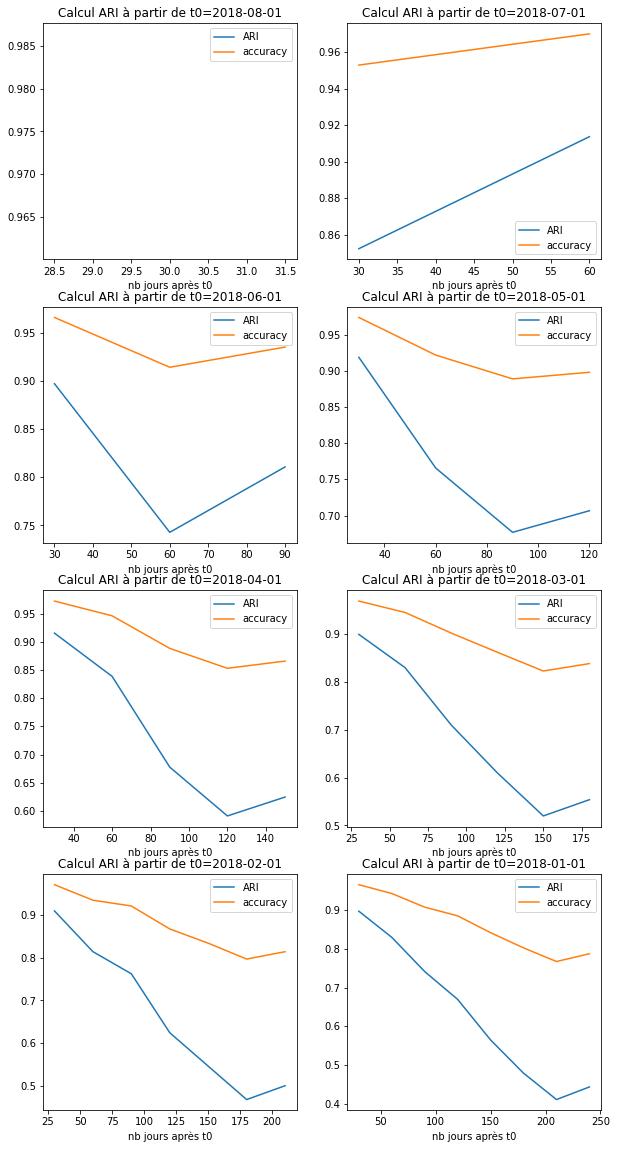

In [13]:
start = timeit.default_timer()
plt.figure(figsize=(10, 20))
compteur = 1
for month in range(8, 0, -1):
    t0 = pd.to_datetime(datetime.date(2018, month, 1))
    nb_periodes = int((9-month))
    plt.subplot(4, 2, compteur)
    plt.title('Calcul ARI à partir de t0={}'.format(t0.strftime('%Y-%m-%d')))
    ari = calcul_ARI(t0,
                     timedelta=30,
                     nb_periodes=nb_periodes,
                     df=data,
                     nb_cluster=6)
    compteur += 1
duree = Affichage_duree(start)

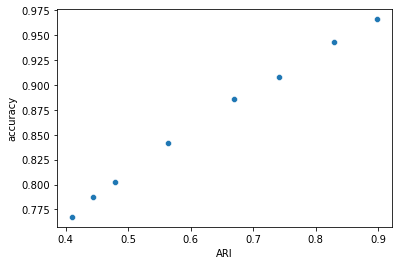

1:49: E703 statement ends with a semicolon


In [14]:
sns.scatterplot(data=ari, x='ARI', y='accuracy');

## freq = 14 jours à partir de différents t0 entre janvier 2018 et aout 2018

Temps d'exécution : 4.81min


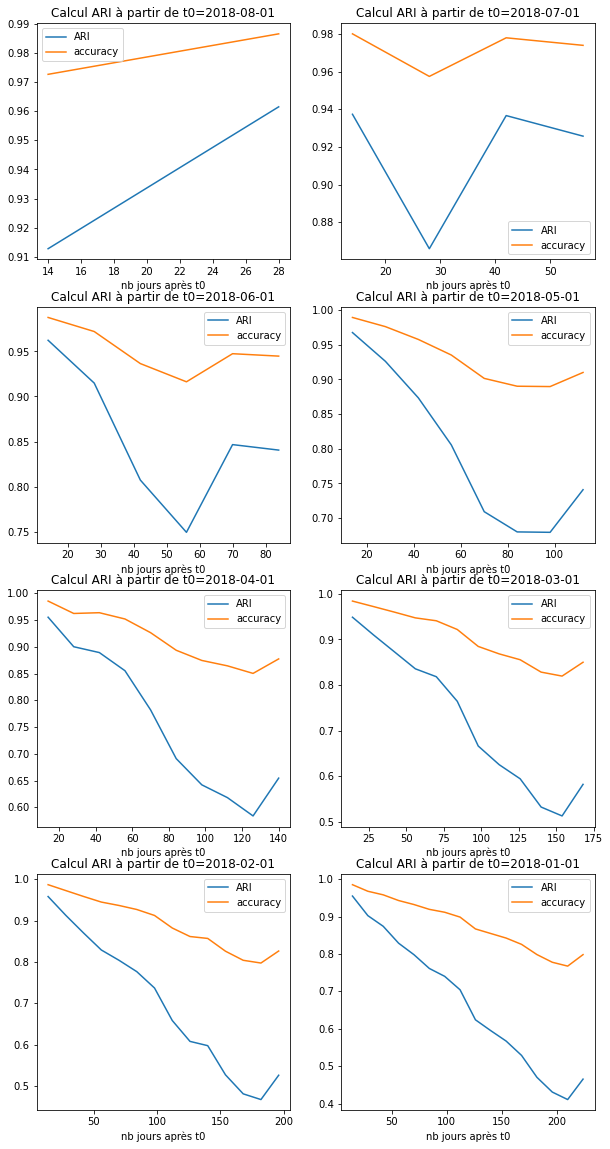

In [15]:
start = timeit.default_timer()
plt.figure(figsize=(10, 20))
compteur = 1
for month in range(8, 0, -1):
    t0 = pd.to_datetime(datetime.date(2018, month, 1))
    nb_periodes = int((9-month)*2)
    plt.subplot(4, 2, compteur)
    plt.title('Calcul ARI à partir de t0={}'.format(t0.strftime('%Y-%m-%d')))
    ari = calcul_ARI(t0,
                     timedelta=14,
                     nb_periodes=nb_periodes,
                     df=data,
                     nb_cluster=6)
    compteur += 1
duree = Affichage_duree(start)

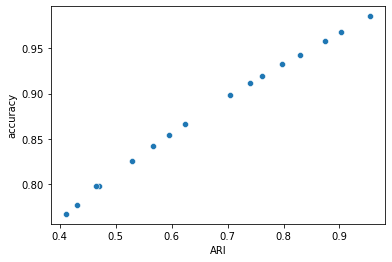

1:49: E703 statement ends with a semicolon


In [16]:
sns.scatterplot(data=ari, x='ARI', y='accuracy');

## freq = 10 jours à partir de différents t0 entre janvier 2018 et aout 2018

Temps d'exécution : 7.79min


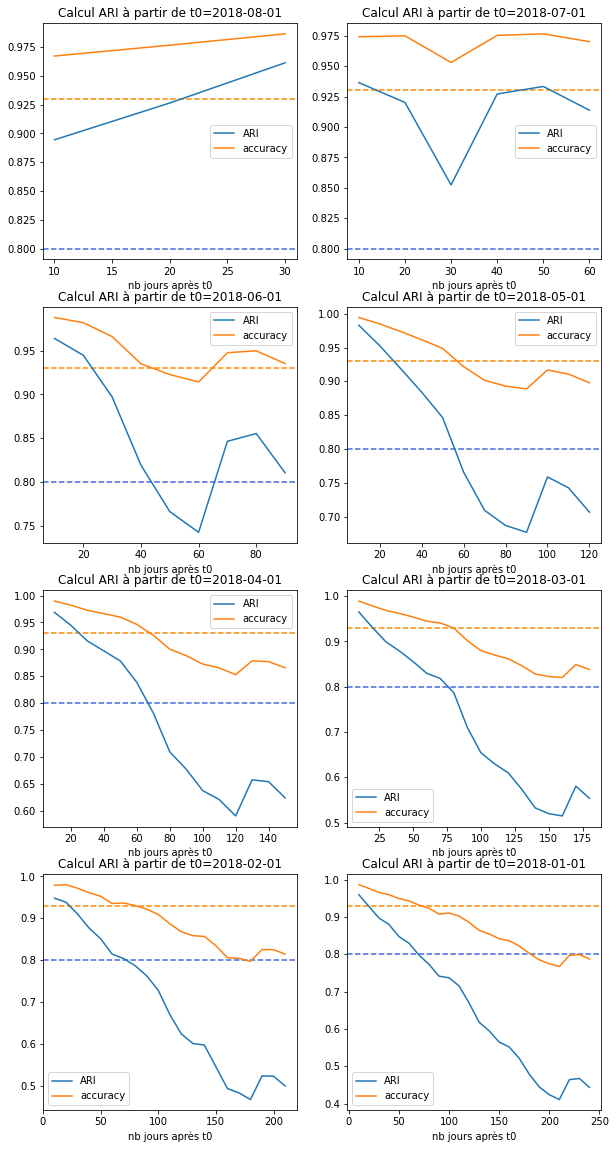

In [30]:
start = timeit.default_timer()
plt.figure(figsize=(10, 20))
compteur = 1
for month in range(8, 0, -1):
    t0 = pd.to_datetime(datetime.date(2018, month, 1))
    nb_periodes = int((9-month)*3)
    plt.subplot(4, 2, compteur)
    plt.title('Calcul ARI à partir de t0={}'.format(t0.strftime('%Y-%m-%d')))
#     plt.axvline(x=60, linewidth=2, color='g')
    plt.axhline(y=0.8, ls='--', color='royalblue')
    plt.axhline(y=0.93, ls='--', color='darkorange')
    ari = calcul_ARI(t0,
                     timedelta=10,
                     nb_periodes=nb_periodes,
                     df=data,
                     nb_cluster=6)
    compteur += 1
duree = Affichage_duree(start)

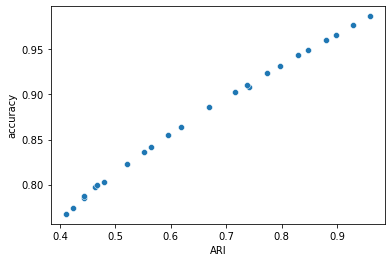

1:49: E703 statement ends with a semicolon


In [18]:
sns.scatterplot(data=ari, x='ARI', y='accuracy');

## freq = 7 jours à partir de différents t0 entre janvier 2018 et aout 2018

Temps d'exécution : 10.42min


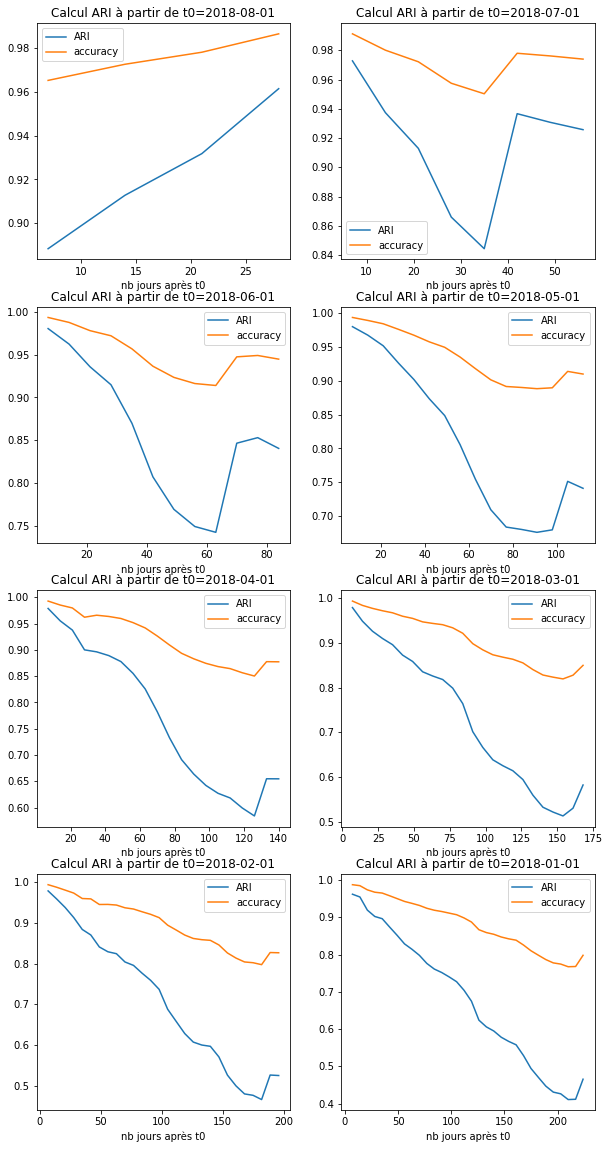

In [19]:
start = timeit.default_timer()
plt.figure(figsize=(10, 20))
compteur = 1
for month in range(8, 0, -1):
    t0 = pd.to_datetime(datetime.date(2018, month, 1))
    nb_periodes = int((9-month)*4)
    plt.subplot(4, 2, compteur)
    plt.title('Calcul ARI à partir de t0={}'.format(t0.strftime('%Y-%m-%d')))
    ari = calcul_ARI(t0,
                     timedelta=7,
                     nb_periodes=nb_periodes,
                     df=data,
                     nb_cluster=6)
    compteur += 1
duree = Affichage_duree(start)

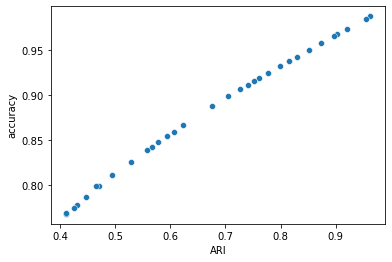

1:49: E703 statement ends with a semicolon


In [20]:
sns.scatterplot(data=ari, x='ARI', y='accuracy');

# Comparaison des clusters entre t0 et t0 + 60j
avec t0 = 01/06/2018

In [21]:
t0 = pd.to_datetime(datetime.date(2018, 6, 1))
nb_cluster = 6

In [22]:
# création de la base de données avant t0
masque_t0 = data.index < t0
data_t0 = data[masque_t0].sort_index()
client_t0 = calcul_features(data_t0)

# creation de la base de donnée post-t0
data_post_t0 = data[~masque_t0].sort_index()

# calcul modèle M0 (= True_pred)
X0 = client_t0.drop(['customer_unique_id'], axis=1)
X0_quanti = list(X0.select_dtypes(['float64', 'int64']).columns)
# mise en place du pipelines pour les données quantitatives
quanti_pipeline = make_pipeline(StandardScaler())
preprocessor_quanti = make_column_transformer((quanti_pipeline, X0_quanti))

M0 = make_pipeline(preprocessor_quanti,
                   KMeans(n_clusters=nb_cluster,
                          random_state=0))
# le modèle est fitté sur les données de t0
M0.fit(X0)

# calcul de la segmentation à t0
cluster_t0 = M0.predict(X0)
X0_scaled = pd.DataFrame(M0['columntransformer'].fit_transform(X0),
                            columns=M0['columntransformer'].get_feature_names_out())

25:29: E127 continuation line over-indented for visual indent
25:80: E501 line too long (84 > 79 characters)


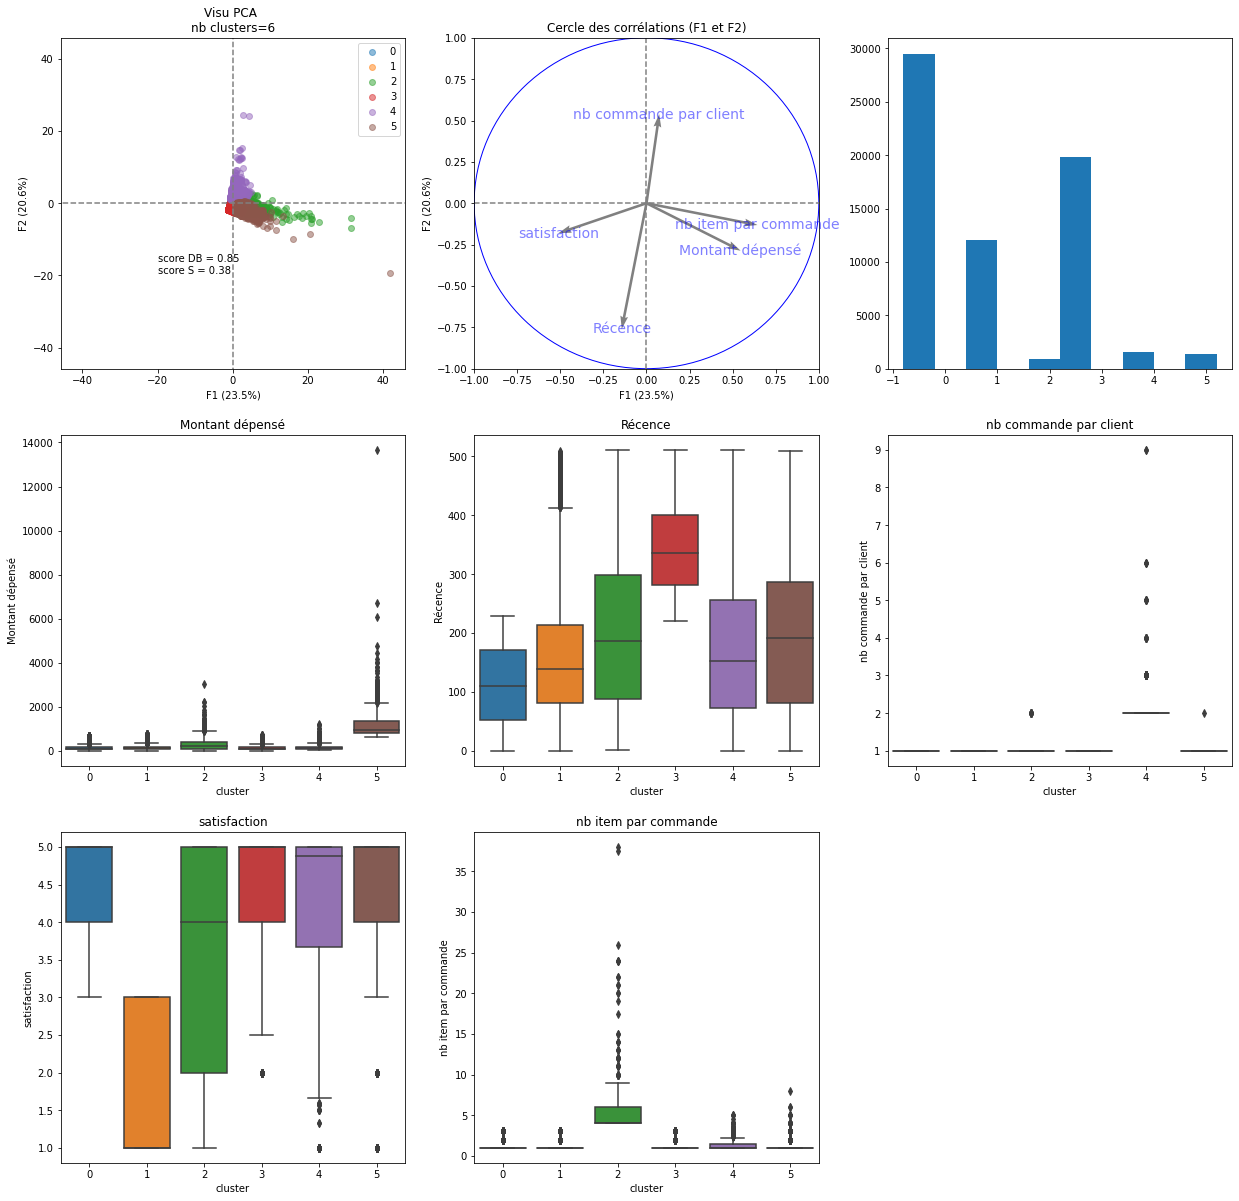

In [23]:
resultat_t0, stats_t0 = visualisation_clustering(X_cluster=cluster_t0,
                                                 X_scaled=X0_scaled,
                                                 X=X0)

Cluster M0 fitté à t0 :
- cluster 0 = clients ayant commandé récemment
- cluster 1 = clients insatisfaits
- cluster 2 = clients ayant commandé plusieurs items par commande, moyennement satisfaits
- cluster 3 = clients n'ayant pas commandé depuis longtemps
- cluster 4 = clients ayant passé plusieurs commandes
- cluster 5 = clients ayant dépensé plus d'argent que les autres

In [24]:
freq = 'D'

# selection des données sur les 60j suivants t0
masque_60j = data_post_t0.index < data_post_t0.index.min() + pd.Timedelta(60, unit=freq)
data_60j = data_post_t0[masque_60j]

data_maj = pd.concat([data_t0, data_60j], axis=0)

# calcul des features
client_maj = calcul_features(data_maj)

# modélisation
X_maj = client_maj.drop(['customer_unique_id'], axis=1)
X_quanti = list(X_maj.select_dtypes(['float64', 'int64']).columns)
# mise en place du pipelines pour les données quantitatives
quanti_pipeline = make_pipeline(StandardScaler())
preprocessor_quanti = make_column_transformer((quanti_pipeline, X_quanti))

M_maj = make_pipeline(preprocessor_quanti,
                      KMeans(n_clusters=nb_cluster,
                             random_state=0))
# le modèle est fitté sur les données de t0+60j
M_maj.fit(X_maj)

# calcul de la segmentation à t0+60j
cluster_maj = M_maj.predict(X_maj)
X_maj_scaled = pd.DataFrame(M_maj['columntransformer'].fit_transform(X_maj),
                            columns=M_maj['columntransformer'].get_feature_names_out())

# calcul de la segmentation qui aurait été prédite par le modèle
# M0 à t0+60j
cluster_M0_60j = M0.predict(X_maj)
X0_60j_scaled = pd.DataFrame(M0['columntransformer'].fit_transform(X_maj),
                             columns=M0['columntransformer'].get_feature_names_out())

# correspondance des clusters M0 et M_maj à t0+60j
# calcul de la matrice de confusion
cm = confusion_matrix(cluster_maj, cluster_M0_60j)
# alignement le long de la diagonale des correspondances des clusters
cluster_M0_60j_modif = cluster_M0_60j.copy()
for i in range(0, 6):
    if np.argmax(cm, axis=1)[i] == i:
        next
    else:
        cluster_M0_60j_modif[cluster_M0_60j == np.argmax(cm, axis=1)[i]] = i

4:80: E501 line too long (88 > 79 characters)
28:80: E501 line too long (87 > 79 characters)
34:80: E501 line too long (85 > 79 characters)


Text(0, 0.5, 'M0-t60j : Modèle M0 appliqué\naux données de t0+60j')

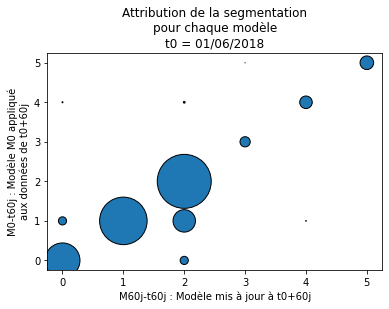

12:80: E501 line too long (80 > 79 characters)


In [25]:
# visualisation des attribution aux classes pour chaque
# segmentation
sizes = {}  # clé : coordonnées ; valeur : nombre de points à ces coordonnées

for (yt, yp) in zip(list(cluster_maj), list(cluster_M0_60j_modif)):
    if (yt, yp) in sizes:
        # incrémente une valeur déjà présente dans le dictionnaire
        sizes[(yt, yp)] += 1
    else:
        # rajoute une entrée au dictionnaire et l'initialise à 1
        sizes[(yt, yp)] = 1

keys = sizes.keys()
plt.title('Attribution de la segmentation\npour chaque modèle\nt0 = 01/06/2018')
plt.scatter([k[0] for k in keys],  # vraie valeur (abscisse)
            [k[1] for k in keys],  # valeur predite (ordonnee)
            s=[0.1*sizes[k] for k in keys],
            edgecolor='black')

plt.xlabel('M60j-t60j : Modèle mis à jour à t0+60j')
plt.ylabel('M0-t60j : Modèle M0 appliqué\naux données de t0+60j')

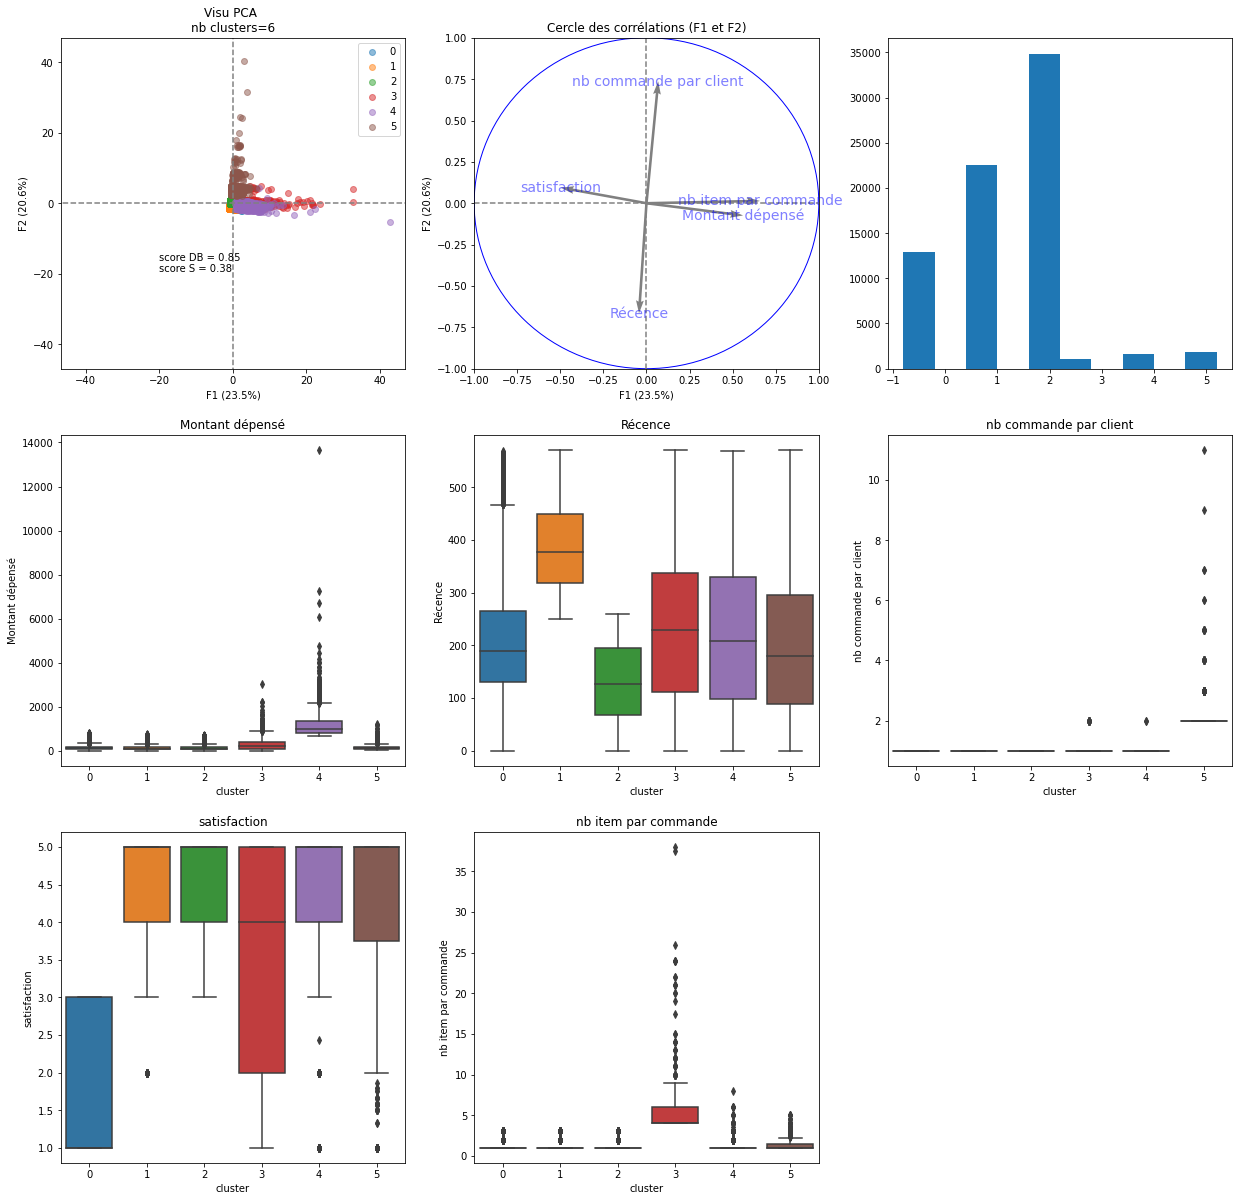

In [26]:
resultat_maj, stats_maj = visualisation_clustering(X_cluster=cluster_maj,
                                                   X_scaled=X_maj_scaled,
                                                   X=X_maj)

Segmentation calculée avec le modèle M_maj à t0 + 60j
- cluster 0 = clients insatisfaits, une seule commande
- cluster 1 = clients ayant commandé il y a longtemps, une seule commande
- cluster 2 = clients récents, une seule commande
- cluster 3 = clients ayant commandé plusieurs item par commande, moyennement satisfaits
- cluster 4 = clients ayant dépensé plus d'argent que les autres
- cluster 5 = clients ayant passé plus d'une commande

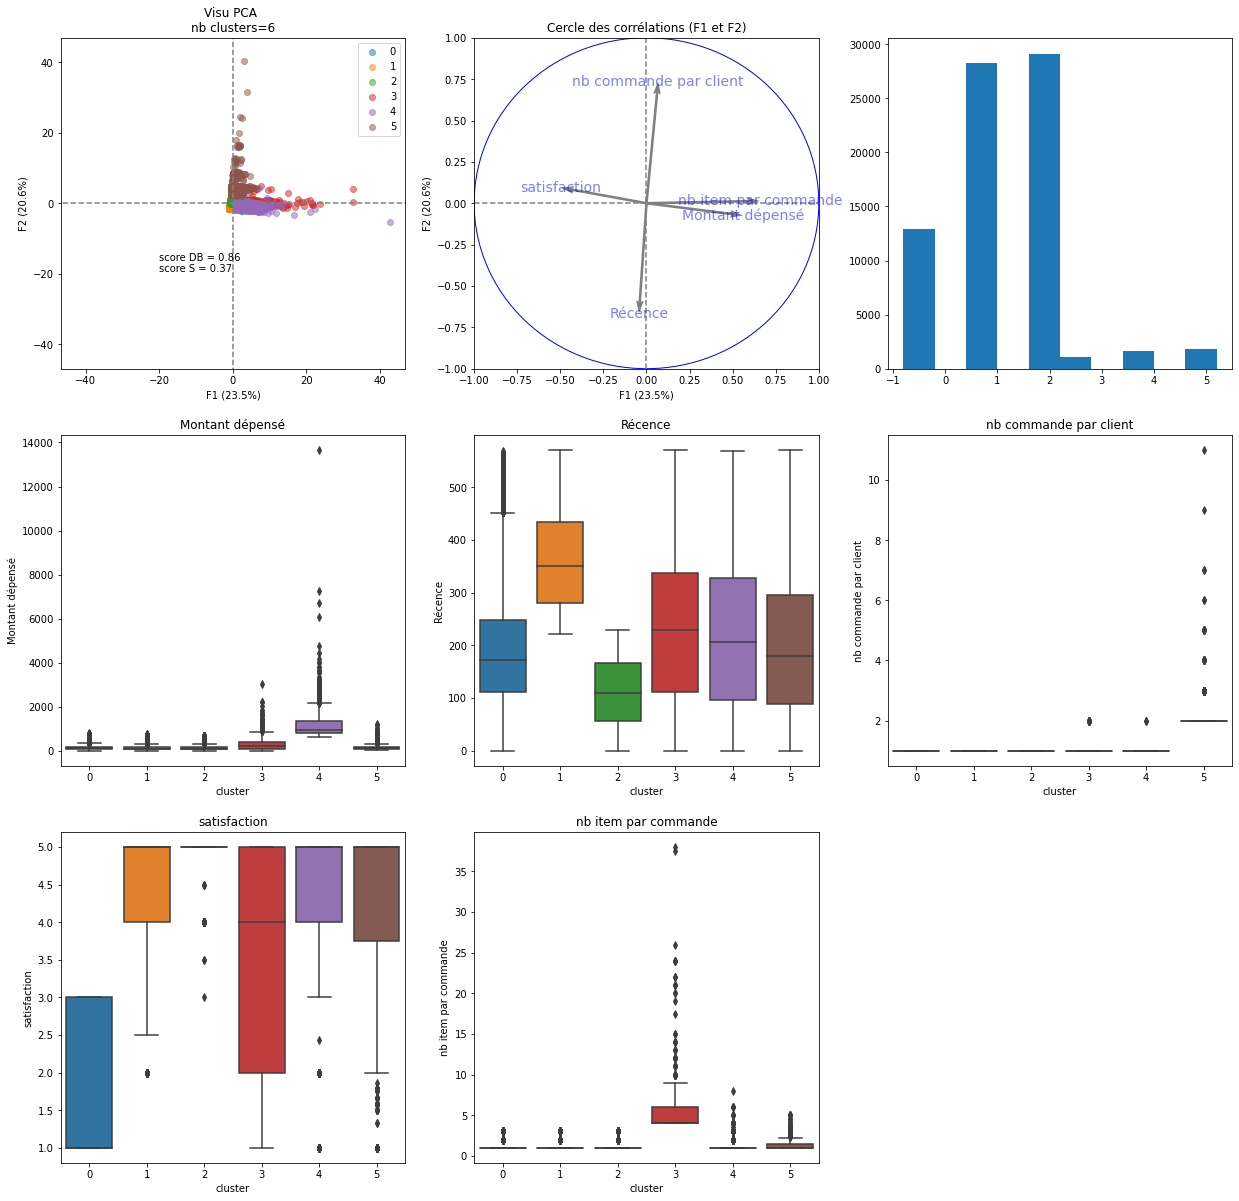

1:80: E501 line too long (88 > 79 characters)
2:80: E501 line too long (80 > 79 characters)


In [27]:
resultat_M0_60j, stats_M0_60j = visualisation_clustering(X_cluster=cluster_M0_60j_modif,
                                                         X_scaled=X0_60j_scaled,
                                                         X=X_maj)

Segmentation calculée avec le modèle M0 à t0 + 60j
- cluster 0 = clients insatisfaits, une seule commande
- cluster 1 = clients ayant commandé il y a longtemps, une seule commande
- cluster 2 = clients récents, une seule commande
- cluster 3 = clients ayant commandé plusieurs item par commande, moyennement satisfaits
- cluster 4 = clients ayant dépensé plus d'argent que les autres
- cluster 5 = clients ayant passé plus d'une commande

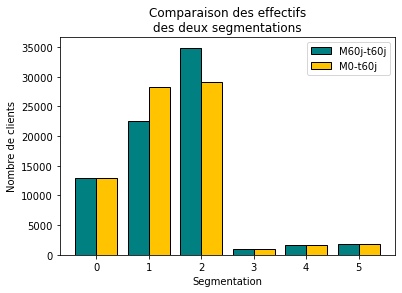

In [28]:
# affichage du nombre d'individu par classe
x1 = resultat_maj['cluster']
x2 = resultat_M0_60j['cluster']
bins = [x + 0.5 for x in range(-1, 6)]
plt.hist([x1, x2], bins=bins, color=['#008080', '#ffc300'],
         edgecolor='black', label=['M60j-t60j', 'M0-t60j'],
         histtype='bar')
plt.ylabel('Nombre de clients')
plt.xlabel('Segmentation')
plt.title('Comparaison des effectifs\ndes deux segmentations')
plt.legend()

In [29]:
resultat_maj

,Montant dépensé,Récence,nb commande par client,satisfaction,nb item par commande,cluster
0,19.62,571,1,5.0,1.0,1
1,18.37,571,4,5.0,1.0,5
2,15.62,571,3,5.0,1.0,5
3,19.62,571,1,5.0,1.0,1
4,20.62,571,1,5.0,1.0,1
...,...,...,...,...,...,...
74829,128.77,0,1,5.0,1.0,2
74830,53.37,0,1,5.0,1.0,2
74831,152.03,0,1,3.0,1.0,2
74832,89.58,0,1,5.0,1.0,2


# Conclusion

MaJ au bout de 60j recommandée